### 사이킷런 Wrapper XGBoost 개요 및 적용 
Boosting 이란?
- 여러 개의 약한 의사결정나무(Decision Tree)를 조합해서 사용하는 앙상블(Ensemble) 기법 중 하나
즉, 약한 예측 모형들의 학습 에러에 가중치를 두고, 순차적으로 다음 학습 모델에 반영하여 강한 예측모형을 만든다.

XGBoost 란?
- XGBoost는 Extreme Gradient Boosting의 약자이다. 해석하면 극한 변화도(경사도) 부스팅
- Boosting 기법을 이용하여 구현한 알고리즘은 Gradient Boost 가 대표적
- 이 알고리즘을 병렬 학습이 지원되도록 구현한 라이브러리가 XGBoost 이다.
- Regression, Classification 문제를 모두 지원하며, 성능과 자원 효율이 좋아서, 인기 있게 사용되는 알고리즘 이다.

XGBoost의 장점
- GBM 대비 빠른 수행시간
- 병렬 처리로 학습, 분류 속도가 빠르다.
- 과적합 규제(Regularization)
- 표준 GBM 경우 과적합 규제기능이 없으나, XGBoost는 자체에 과적합 규제 기능으로 강한 내구성 지닌다.
- 분류와 회귀영역에서 뛰어난 예측 성능 발휘
- 즉, CART(Classification and regression tree) 앙상블 모델을 사용
- Early Stopping(조기 종료) 기능이 있음
- 다양한 옵션을 제공하며 Customizing이 용이하다.
- Missing Values : 결측치를 내부적으로 처리해준다. 실제로 kaggle에 적용해보는 과정에서 편리함


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

dataset = load_breast_cancer()
X = dataset.data
y = dataset.target

df = pd.DataFrame(X, columns=dataset.feature_names)
df['target'] = y

In [3]:
df[df.target==1].head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
19,13.540,14.36,87.46,566.3,0.09779,0.08129,0.06664,0.047810,0.1885,0.05766,...,19.26,99.70,711.2,0.14400,0.17730,0.23900,0.12880,0.2977,0.07259,1
20,13.080,15.71,85.63,520.0,0.10750,0.12700,0.04568,0.031100,0.1967,0.06811,...,20.49,96.09,630.5,0.13120,0.27760,0.18900,0.07283,0.3184,0.08183,1
21,9.504,12.44,60.34,273.9,0.10240,0.06492,0.02956,0.020760,0.1815,0.06905,...,15.66,65.13,314.9,0.13240,0.11480,0.08867,0.06227,0.2450,0.07773,1
37,13.030,18.42,82.61,523.8,0.08983,0.03766,0.02562,0.029230,0.1467,0.05863,...,22.81,84.46,545.9,0.09701,0.04619,0.04833,0.05013,0.1987,0.06169,1
46,8.196,16.84,51.71,201.9,0.08600,0.05943,0.01588,0.005917,0.1769,0.06503,...,21.96,57.26,242.2,0.12970,0.13570,0.06880,0.02564,0.3105,0.07409,1


In [4]:
print(f'악성 환자 {len(df[df.target==0])}명, 양성 환자 {len(df[df.target==1])}명')

악성 환자 212명, 양성 환자 357명


In [5]:
# 악성, 양성
# 악성 - 주변으로 퍼짐 (전염성 크다) / 양성 - 종양의 크기만 커짐 (전염성 낮다)
print(dataset.target_names)
print(df.target.value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=156)

In [7]:
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, prob=None):
    AS = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    confusion = confusion_matrix(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, prob)
    
    print(f'오차행렬 : \n{confusion}\n\nTN = {confusion[0, 0]}, FP = {confusion[0, 1]}\nFN = {confusion[1, 0]}, TP = {confusion[1, 1]}\n')
    print(f'정확도: {round(AS,4)}, 정밀도: {round(precision,4)}, \
재현율: {round(recall,4)}, f1 score: {round(f1,4)}, \
AUC: {round(auc,4)}')

In [9]:
#!pip install xgboost

In [16]:
from xgboost import XGBClassifier

evals = [(X_test, y_test)]
xgb = XGBClassifier(n_estimator=400, learning_rate=0.1, max_depth=3)
xgb.fit(X_train, y_train, early_stopping_rounds=100, eval_set=evals,
       eval_metric = 'logloss',verbose=True)
pred = xgb.predict(X_test)
prob = xgb.predict_proba(X_test)[:,1]

[12:42:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validat

In [17]:
get_clf_eval(y_test, pred, prob)

오차행렬 : 
[[34  3]
 [ 2 75]]

TN = 34, FP = 3
FN = 2, TP = 75

정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.974, f1 score: 0.9677, AUC: 0.9947


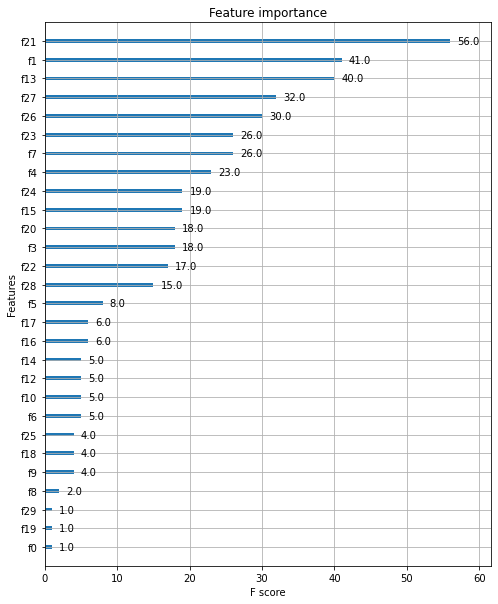

In [19]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,10))
plot_importance(xgb, ax=ax)
plt.show()

In [ ]:
import lightgbm
print(lightgbm.__version__)

## LightGBM

LightGBM의 트리 분할 방식
- 일반적인 GBM 계열의 트리 분할 방식은 균형 트리 분할(Level Wise) 방식을 이용합니다. 이 방법을 이용하면 최대한 균형 잡힌 트리를 생성하면서도 트리의 깊이를 최소화 할 수 있다는 장점이 있습니다. 이러한 방식으로 트리를 생성할 경우 과적합 문제에 더 강한 구조를 갖게 되지만 균형을 맞추기 위한 시간이 필요하다는 단점이 있습니다.
- 반면 LightGBM의 경우 일반적인 균형 트리 분할 방식과 다르게 리프 중심 트리 분할(Leaf Wise) 방식을 이용합니다.
- 이 방법은 트리의 균형을 맞추지 않고 최대 손실 값(max delta loss)을 가지는 리프 노드를 지속적으로 분할하면서 트리가 깊어지고 비대칭 적인 트리를 만듭니다. 하지만 이러한 방식으로 트리를 계속해서 분할하게 되면 결국 균형 트리 분할 방식보다 예측 오류 손실을 최소화 한다는 방법을 이용

LightGBM과 XGBoost를 비교시 장점

- 빠른 학습 및 예측 수행 시간
- 더 작은 메모리 사용량
- 카테코리형 피처의 자동 변환 및 최적 분할

LightGBM은 이러한 장점을 가지고 있지만 공식 문서에 따르면 일반적으로 10,000 건 이하의 데이터 세트를 다루는 경우 과적합 문제가 발생하기 쉽다는 단점이 있음

https://kimdingko-world.tistory.com/184

In [21]:
# LightGBM 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# 위스콘신 유방암 데이터 로드
dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

# LGBM 분류기 객체 생성
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=156)
lgbm = LGBMClassifier(n_estimators=400)
evals = [(X_test,y_test)]
lgbm.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)
pred = lgbm.predict(X_test)
prob = lgbm.predict_proba(X_test)[:,1]

[1]	valid_0's binary_logloss: 0.565079
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_logloss: 0.151113
[25]	valid_0's binary_logloss: 0.148395
[26]	vali

In [23]:
get_clf_eval(y_test,pred,prob)

오차행렬 : 
[[33  4]
 [ 1 76]]

TN = 33, FP = 4
FN = 1, TP = 76

정확도: 0.9561, 정밀도: 0.95, 재현율: 0.987, f1 score: 0.9682, AUC: 0.9905


In [24]:
for i, name in enumerate(dataset.feature_names):
    print(i,name)

0 mean radius
1 mean texture
2 mean perimeter
3 mean area
4 mean smoothness
5 mean compactness
6 mean concavity
7 mean concave points
8 mean symmetry
9 mean fractal dimension
10 radius error
11 texture error
12 perimeter error
13 area error
14 smoothness error
15 compactness error
16 concavity error
17 concave points error
18 symmetry error
19 fractal dimension error
20 worst radius
21 worst texture
22 worst perimeter
23 worst area
24 worst smoothness
25 worst compactness
26 worst concavity
27 worst concave points
28 worst symmetry
29 worst fractal dimension


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

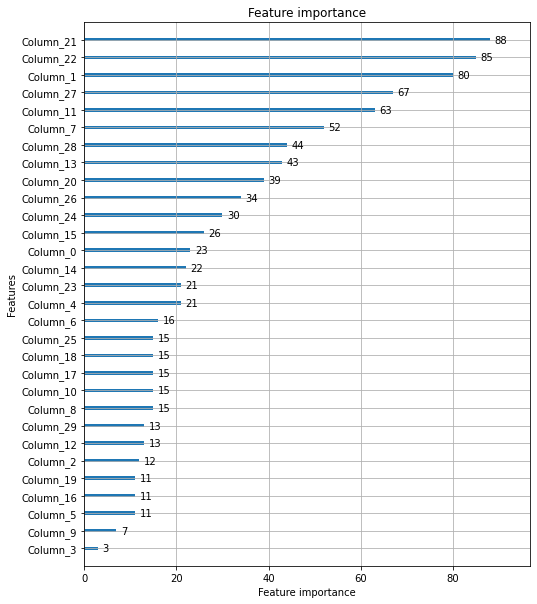

In [28]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(8,10))
plot_importance(lgbm,ax=ax)

In [30]:
ax

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>